- Load necessary module

In [ ]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
np.random.seed(1)
mat = io.loadmat('tempNs4.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
model['Ns'] = mat['Ns'][0,0] ## need to change nb of stream in channel realization, this case 1
# model['Ns'] = 2
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 4
archi = 'FC'

In [3]:
for key in model:
    print(key)

H
Wopt
Fopt
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


In [4]:
model['Ns']

4

Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [5]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=3)

def generate_candidat(S,model,phase_value,ps_system_proba,archi):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
#     print(ps_system_proba)
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    if (archi == 'FC' or archi == 'FCOMP'):
        for i in range(S):
            for j in range(model['Nt']):
                for k in range(model['Nrf']):
                    F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    if archi == 'PC':
        only_PS = np.zeros((S,model['Nt']),dtype=complex)
        m = int(model['Nt']/model['Nrf'])
        for i in range(S):
            for j in range(model['Nt']):
                only_PS[i,j] = np.random.choice(phase_value, 1, p=ps_system_proba[j,:])
            for k in range(model['Nrf']):
                F_rf[i,k*m:(k+1)*m,k] = only_PS[i,k*m:(k+1)*m]
    return F_rf

def compute_Fbb(F_rf,model,channel):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
#     channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  channel@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(channel, full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite,R_elite,ps_system_proba,archi):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    assign = np.zeros(nb_elite)
    weight = R_elite/np.mean(R_elite)
#     print(weight.shape)
#     print(assign.shape)
#     print(F_elites.shape)
    if (archi == 'FC' or archi == 'FCOMP'):
        for i in range(model['Nt']):
            for j in range(model['Nrf']):
                for k in range(nb_state):
                    assign = F_elites[:,i,j] == phase_value[k]
#                     print(assign.shape)
#                     print(weight.shape)
                    proba_est = np.sum(assign*weight)/nb_elite
#                     proba_est = np.sum(assign)/nb_elite
                    ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    if archi == 'PC':
        # Convert to PC form
        F_RF_conv = np.zeros((F_elites.shape[0],model['Nt']),dtype=complex)
        
        m = int(model['Nt']/model['Nrf'])
        for i in range(F_elites.shape[0]):
            f_rf = F_elites[i,:]
            f_rf_conv = f_rf[0:m,0]
            for j in range(model['Nrf']-1):
                f_rf_conv = np.concatenate((f_rf_conv,f_rf[(j+1)*m:(j+2)*m,j+1]))
            F_RF_conv[i,:] = f_rf_conv
    
    
        for i in range(model['Nt']):
            for k in range(nb_state):
                assign = F_RF_conv[:,i] == phase_value[k]
                proba_est = np.sum(assign*weight)/nb_elite
#                 proba_est = np.sum(assign)/nb_elite
                ps_system_proba[i,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,k]   
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [6]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [7]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [ ]:
# ps_system_proba = np.ones((model['Nt'],nb_state))*(1/nb_state)
# F_rf = generate_candidat(S,model,phase_value,ps_system_proba,'PC')

In [ ]:
# F_RF_conv[0,:]

In [ ]:
# F_RF_conv = np.zeros((F_rf.shape[0],model['Nt']),dtype=complex)
# m = int(model['Nt']/model['Nrf'])
# for i in range(F_rf.shape[0]):
#     f_rf = F_rf[i,:]
#     f_rf_conv = f_rf[0:m,0]
#     for j in range(model['Nrf']-1):
#         f_rf_conv = np.concatenate((f_rf_conv,f_rf[(j+1)*m:(j+2)*m,j+1]))
#     F_RF_conv[i,:] = f_rf_conv

In [ ]:
# test = F_rf[0,:]
# m = int(model['Nt']/model['Nrf'])

In [ ]:
# test2 = test[0:m,0]
# print(test2)
# for i in range(model['Nrf']-1):
#     print(i+1)
#     test2 = np.concatenate((test2,test[(i+1)*m:(i+2)*m,i+1]))
# #     print(test[(i+1)*m:(i+2)*m,i+1])

In [8]:
def OMP(_Fopt,_NRF,_At):
    """
    Orthogonal matching pursuit for hybrid beamforming
    
    """
    _FRF = np.empty((_At.shape[0],0))
    _Fres = _Fopt
    for k in range(_NRF):
        PU = _At.conj().T@_Fres
        ind = np.argmax(np.sum((np.absolute(PU))**2,axis=1))
        _FRF = np.append(_FRF,_At[:,[ind]],axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    _FBB = np.sqrt(model['Ns'])*_FBB/np.linalg.norm(_FRF@_FBB,'fro')
    return _FRF,_FBB

In [9]:
def quantize_Frf(model,n_bit,F_rf,channel_index):
    """
    Quantize precoder for low resolutioin phase shifter
    
    """
    q = 2*np.pi/2**n_bit
    amplitude = 1/np.sqrt(model['Nt'])
    Frf_angle = np.angle(F_rf)
    angle_quantized = q * np.round(Frf_angle/q)
    Frf_quantized = amplitude*np.exp(1j*angle_quantized)
    Frf_quantized = np.around(Frf_quantized, decimals=3)
    
    channel_eq =  model['H'][:,:,channel_index]@Frf_quantized
    U, s, V = np.linalg.svd(channel_eq, full_matrices=True)
    V = V.conj().T
    F_bb = V[0:model['Nt'],0:model['Ns']]
    F_bb = np.sqrt(model['Ns'])*F_bb/np.linalg.norm(Frf_quantized@F_bb,'fro')
    
    return Frf_quantized, F_bb

In [10]:
def quantize_Frf(model,n_bit,F_rf,channel_index):
    """
    Quantize precoder for low resolutioin phase shifter
    
    """
    q = 2*np.pi/2**n_bit
    amplitude = 1/np.sqrt(model['Nt'])
    Frf_angle = np.angle(F_rf)
    angle_quantized = q * np.round(Frf_angle/q)
    Frf_quantized = amplitude*np.exp(1j*angle_quantized)
    Frf_quantized = np.around(Frf_quantized, decimals=3)
    
    channel_eq =  model['H'][:,:,channel_index]@Frf_quantized
    U, s, V = np.linalg.svd(channel_eq, full_matrices=True)
    V = V.conj().T
    F_bb = V[0:model['Nt'],0:model['Ns']]
    F_bb = np.sqrt(model['Ns'])*F_bb/np.linalg.norm(Frf_quantized@F_bb,'fro')
    
    return Frf_quantized, F_bb

In [11]:
def initialize_pmf_omp(model,nb_bit,Frf_omp_quantize,phase_value,ratio):
    """
    Initialize pmf of phase shifter with solution getting by OMP
    
    """
    low_proba = 1/(2**nb_bit-1+ratio)
    high_proba = ratio*low_proba
    proba_init = np.zeros((model['Nt'],model['Nrf'],2**nb_bit))
    for i in range(phase_value.shape[0]):
        assign = Frf_omp_quantize == phase_value[i]
        proba_init[:,:,i] = assign*high_proba + np.invert(assign)*low_proba
    return proba_init

In [ ]:
model['Fopt'][:,:,channel_index].shape

In [ ]:
model['Nrf']

In [ ]:
ps_system_proba_omp

In [ ]:
FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] )# ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)


In [ ]:
R = np.zeros((S))
Fopt, Wopt = model['Fopt'][:,:,channel_index],model['Wopt'][:,:,channel_index]
FRF_omp, FBB_omp = OMP( Fopt, model['Nrf'], model['At'][:,:,channel_index] )# ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)
ps_system_proba = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
relative_std = 1000 # initialize high value of relative standard deviation
i = 0

In [ ]:
F_rf = generate_candidat(S,model,phase_value,ps_system_proba,archi)
F_bb = compute_Fbb(F_rf,model,model['H'][:,:,channel_index])

In [ ]:
SNR = 10**(10/10)
for j in range(S):
    R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
R_sort_index = np.argsort(R)[::-1][:nb_elite]
if i==0:
    R_max = R[R_sort_index[0]]
else:
    R_max = np.append(R_max,R[R_sort_index[0]])
F_elites = F_rf[R_sort_index,:,:]
Frf_max = F_rf[R_sort_index[0],:,:]
Fbb_max = F_bb[R_sort_index[0],:,:]

In [ ]:
F_rf

In [ ]:
ps_system_proba = update_pmf(F_elites,phase_value,nb_elite,R[R_sort_index],ps_system_proba,archi)

In [ ]:
CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'FCOMP')

In [12]:
def CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,SNR,archi):
    """
    Hybrid beamforming by Cross-entropy method
    
    """
    phase_value = phase_shifter(nb_bit,model['Nt'])
    Fopt, Wopt = model['Fopt'][:,:,channel_index],model['Wopt'][:,:,channel_index]
    if archi == 'FC':
        ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
#         proba_evo = np.copy(ps_system_proba[0,0,:])
    elif archi == 'PC':
        ps_system_proba = np.ones((model['Nt'],nb_state))*(1/nb_state)
#         proba_evo = np.copy(ps_system_proba[0,:])
#     print(ps_system_proba)
    elif archi == 'FCOMP':
        FRF_omp, FBB_omp = OMP( Fopt, model['Nrf'], model['At'][:,:,channel_index] )# ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
        Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)
        ps_system_proba = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)

    relative_std = 1000 # initialize high value of relative standard deviation
    i = 0
    while ((i<nb_iterate) and (relative_std>3)):
#         print(ps_system_proba)
        F_rf = generate_candidat(S,model,phase_value,ps_system_proba,archi)
        F_bb = compute_Fbb(F_rf,model,model['H'][:,:,channel_index])
#         print(F_bb)
        R = np.zeros((S))
        for j in range(S):
            R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
#         print(R)
        R_sort_index = np.argsort(R)[::-1][:nb_elite]
        if i==0:
            R_max = R[R_sort_index[0]]
        else:
            R_max = np.append(R_max,R[R_sort_index[0]])
        F_elites = F_rf[R_sort_index,:,:]
        Frf_max = F_rf[R_sort_index[0],:,:]
        Fbb_max = F_bb[R_sort_index[0],:,:]
        ps_system_proba = update_pmf(F_elites,phase_value,nb_elite,R[R_sort_index],ps_system_proba,archi)
#         if archi == 'FC':
#             proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
#         elif archi == 'PC':
#             proba_evo = np.vstack((proba_evo,ps_system_proba[0,:]))
#         print(R[R_sort_index[0]])
        
        if i>=5:
            R_max_normalize = R_max-np.min(R_max) ## Need to review
            relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
#             print(relative_std)
        i +=1
    output = {}
    output['R_max'] = R_max
    output['Frf_max'] = Frf_max
    output['Fbb_max'] = Fbb_max
    output['nb_ite'] = i
#     output['proba_evo'] = proba_evo
    output['ps_system_proba'] = ps_system_proba
    return output

In [13]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
# if archi == 'FC':
#     ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
# elif archi == 'PC':
#     ps_system_proba = np.ones((model['Nt'],nb_state))*(1/nb_state)
SNR_dB = np.arange(-30,15,5)
# SNR = 10**(SNR_dB/10)
# SNR = 10**(10/10)
# smax = SNR.shape[0]

In [ ]:
# Evolution of pmf of 1 phase shifter
# np.around(CE_result['ps_system_proba'], decimals=3)

In [ ]:
rate_CE_PC = np.zeros((SNR_dB.shape[0]))
sum_rate_CE_PC = np.zeros((SNR_dB.shape[0]))
CE_nb_ite = 0
sum_nb_ite = 0
for channel_index in range(5):
    print('index: ' + str(channel_index))
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'PC')
    CE_nb_ite = CE_result['nb_ite']
    for i in range(SNR_dB.shape[0]):
        rate_CE_PC[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],CE_result['Frf_max']@CE_result['Fbb_max'])
    sum_rate_CE_PC = sum_rate_CE_PC + rate_CE_PC
    sum_nb_ite = CE_nb_ite + sum_nb_ite
    print(sum_nb_ite)
    print(rate_CE_PC)

In [ ]:
rate_CE_FC = np.zeros((SNR_dB.shape[0]))
sum_rate_CE_FC = np.zeros((SNR_dB.shape[0]))
CE_nb_ite = 0
sum_nb_ite = 0
for channel_index in range(2):
    print('index: ' + str(channel_index))
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'FC')
    CE_nb_ite = CE_result['nb_ite']
    for i in range(SNR_dB.shape[0]):
        rate_CE_FC[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],CE_result['Frf_max']@CE_result['Fbb_max'])
    sum_rate_CE_FC = sum_rate_CE_FC + rate_CE_FC
    sum_nb_ite = CE_nb_ite + sum_nb_ite
    print(rate_CE_FC)
    print(sum_nb_ite)

In [ ]:
sum_rate_CE_FC

In [ ]:
# print('Data rate evolution: ' + str(CE_result['R_max']))
# plt.plot(CE_result['R_max'])
# plt.title('data rate against iteration - 2 bits PS')
# plt.ylabel('data rate (bps/Hz)')
# plt.xlabel('iteration')
# print('Number of iteration: ' + str(CE_result['nb_ite']))
# print('Phase shifter pmf' + str(np.around(CE_result['proba_evo'], decimals=3)))

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [ ]:
model['Ns']

In [ ]:
R_o = data_rate(model['Ns'],10**(10/10),model['Wopt'][:,:,0],model['H'][:,:,0],model['Fopt'][:,:,0])
print('Data rate by digital beamforming: ' + str(R_o))

In [ ]:
# Normalize condition
x = np.linalg.norm(CE_result['Frf_max']@CE_result['Fbb_max'],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

In [ ]:
digital_rate = np.zeros((SNR_dB.shape[0]))
sum_digital_rate = np.zeros((SNR_dB.shape[0]))
for channel_index in range(5):
    print('index: ' + str(channel_index))
    for i in range(SNR_dB.shape[0]):
        digital_rate[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],model['Fopt'][:,:,channel_index])
    sum_digital_rate = sum_digital_rate + digital_rate
    print(digital_rate)

In [14]:
rate_CE_OMP = np.zeros((SNR_dB.shape[0]))
sum_rate_CE_OMP = np.zeros((SNR_dB.shape[0]))
CE_nb_ite = 0
sum_nb_ite = 0
for channel_index in range(5):
    print('index: ' + str(channel_index))
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'FCOMP')
    CE_nb_ite = CE_result['nb_ite']
    for i in range(SNR_dB.shape[0]):
        rate_CE_OMP[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],CE_result['Frf_max']@CE_result['Fbb_max'])
    sum_rate_CE_OMP = sum_rate_CE_OMP + rate_CE_OMP
    sum_nb_ite = CE_nb_ite + sum_nb_ite
    print(rate_CE_OMP)
    print(sum_nb_ite)

index: 0
[ 0.18661387  0.55791239  1.53190005  3.64873939  7.33140125 12.4789617
 18.52503972 24.96149847 31.53763229]
18
index: 1
[ 0.21788584  0.65645889  1.82700594  4.38301217  8.6573563  14.25060331
 20.50939733 27.02474768 33.62723045]
38
index: 2
[ 0.16292204  0.49908553  1.44243594  3.66895335  7.67133998 13.12831402
 19.33594118 25.83417629 32.43114959]
58
index: 3
[ 0.2562534   0.75859313  2.03394796  4.63757217  8.81535757 14.28158128
 20.47086378 26.9594419  33.55288347]
78
index: 4
[ 0.23129672  0.68997756  1.88283512  4.4133128   8.60133808 14.11866824
 20.34081556 26.84266912 33.44066203]
97


In [ ]:
OMP( Fopt, model['Nrf'], model['At'][:,:,channel_index] )

In [ ]:
model['At'][:,:,channel_index] 

array([  19.54922669,   58.2922556 ,  158.79208973,  369.28672871,
        706.87896155, 1135.99094508, 1609.32176865, 2099.33372726,
       2594.96375472])

In [ ]:
SNR_dB

In [21]:
sum_rate_CE_OMP/5

array([ 0.21099438,  0.6324055 ,  1.743625  ,  4.15031797,  8.21535864,
       13.65162571, 19.83641152, 26.32450669, 32.91791157])

In [15]:
OMP = np.array([ 0.22317937,  0.65307923,  1.7242831 ,  3.89130729,  7.38210255,
       12.0446525 , 17.52735967, 23.49692577, 29.73026376])
quan_OMP = np.array([ 0.15360772,  0.46233855,  1.28936884,  3.13826287,  6.41532018,
       11.08009538, 16.72319897, 22.90968806, 29.3595054 ])
sum_rate_CE_PC = np.array([  0.52366061,   1.60358201,   4.64395702,  12.00925971,
        26.37698906,  48.61650672,  76.83223108, 108.17246538,
       140.75704393])
sum_rate_CE_FC = np.array([ 0.32917173,  1.00278803,  2.86268021,  7.16043021, 14.83647874,
       25.44730884, 37.70663827, 50.64386273, 63.81787168])
sum_digital_rate = np.array([  1.59151382,   4.67524429,  12.36836586,  27.68981093,
        51.23774157,  80.39861587, 112.17409253, 144.91729675,
       177.98393834])

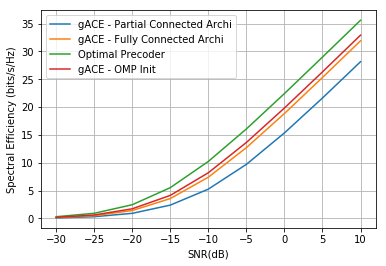

In [18]:
plt.plot(SNR_dB, sum_rate_CE_PC/5, label='gACE - Partial Connected Archi')
plt.plot(SNR_dB, sum_rate_CE_FC/2, label='gACE - Fully Connected Archi')
plt.plot(SNR_dB, sum_digital_rate/5, label='Optimal Precoder')
plt.plot(SNR_dB, sum_rate_CE_OMP/5, label='gACE - OMP Init')
# plt.plot(SNR_dB, OMP, label='OMP Precoder')
# plt.plot(SNR_dB, quan_OMP, label='quan_OMP')
# plt.plot(SNR_dB, (sum_rate_CE_FC-sum_rate_CE_PC)/5, label='FC')
plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()

In [ ]:
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] ) 

In [ ]:
x = np.linalg.norm(FRF_omp@FBB_omp,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

In [ ]:

SNR_dB = np.arange(-30,15,5)
OMP_rate = np.zeros((SNR_dB.shape[0]))
sum_OMP_rate = np.zeros((SNR_dB.shape[0]))
for channel_index in range(100):
#     print('index: ' + str(channel_index))
    FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] )
    for i in range(SNR_dB.shape[0]):
        OMP_rate[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],FRF_omp@FBB_omp)
    sum_OMP_rate = sum_OMP_rate + OMP_rate
#     print(OMP_rate)

In [ ]:
sum_OMP_rate/100

In [ ]:

SNR_dB = np.arange(-30,15,5)
OMP_quan_rate = np.zeros((SNR_dB.shape[0]))
sum_OMP_quan_rate = np.zeros((SNR_dB.shape[0]))
for channel_index in range(100):
#     print('index: ' + str(channel_index))
    FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] )
    Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)
    for i in range(SNR_dB.shape[0]):
        OMP_quan_rate[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],Frf_quantize@Fbb_quantize)
    sum_OMP_quan_rate = sum_OMP_quan_rate + OMP_quan_rate
#     print(OMP_quan_rate)

In [ ]:
sum_OMP_quan_rate/100

In [ ]:
# Normalize condition
x = np.linalg.norm(Frf_quantize@Fbb_quantize,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

In [ ]:
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
ps_system_proba_omp

In [ ]:
rate_CE_OMP= np.zeros((SNR_dB.shape[0]))
sum_rate_CE_OMP = np.zeros((SNR_dB.shape[0]))
for channel_index in range(2):
    print('index: ' + str(channel_index))
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'FC')
    for i in range(SNR_dB.shape[0]):
        rate_CE_FC[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],CE_result['Frf_max']@CE_result['Fbb_max'])
    sum_rate_CE_FC = sum_rate_CE_FC + rate_CE_FC
    print(rate_CE_FC)